---
title: PA 6.2 
author: Marvin (Wenxiang) Li
format:
    html:
        toc: true
        code-fold: true
embed-resources: true        
---

# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [1]:
pip install palmerpenguins

In [2]:
import palmerpenguins as p
import numpy as np
import pandas as pd

In [3]:
penguins = p.load_penguins()
penguins = penguins.dropna().reset_index(drop=True) # must reset index to match dummy variables
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on a training dataset subset of the entire dataset:

* Four different models, each containing a different set of predictor variables

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

In [5]:
# Picking independent variables
X = penguins.drop("bill_depth_mm", axis = 1)
y = penguins["bill_depth_mm"]
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Check X_train

In [6]:
X_train.head(3)

,species,island,bill_length_mm,flipper_length_mm,body_mass_g,sex,year
224,Gentoo,Biscoe,49.1,212.0,4625.0,female,2009
78,Adelie,Dream,37.3,191.0,3350.0,female,2008
295,Chinstrap,Dream,40.9,187.0,3200.0,female,2008


- Model 1

In [7]:
# Model y = body_mass + sex
ct1 = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(drop='first', sparse_output = False), ["sex"]),
    ("standardize", StandardScaler(), ["body_mass_g"])
  ],
  remainder = "drop"
)
# pipeline
lr_pipeline1 = Pipeline([
    ("preprocessor", ct1),  # First step: scale and dummy
    ("regressor", LinearRegression())  # Second step: apply linear regression
])

In [8]:
lr_pipeline1.fit(X_train, y_train)
train_pred = lr_pipeline1.predict(X_train)
test_pred = lr_pipeline1.predict(X_test)

In [9]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

In [10]:
# Calculate evaluation metrics
result1 = pd.DataFrame([{
        "model": "model 1",
        "num_of_features": ct1.fit_transform(X_train).shape[1],
        "train_mse": mean_squared_error(y_train, train_pred),
        "test_mse": mean_squared_error(y_test, test_pred),
        "r2_train": r2_score(y_train, train_pred),
        "r2_test": r2_score(y_test, test_pred),
        "rmse_train": root_mean_squared_error(y_train, train_pred),
        "rmse_test": root_mean_squared_error(y_test, test_pred)
  }])
result1

,model,num_of_features,train_mse,test_mse,r2_train,r2_test,rmse_train,rmse_test
0,model 1,2,1.398068,1.70616,0.638063,0.540367,1.182399,1.3062


- Model 2


In [11]:
# Model y = body_mass + species + sex
ct2 = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(drop='first', sparse_output = False), ["species", "sex"]),
    ("standardize", StandardScaler(), ["body_mass_g"])
  ],
  remainder = "drop"
)
# pipeline
lr_pipeline2 = Pipeline([
    ("preprocessor", ct2),  # First step: scale and dummy
    ("regressor", LinearRegression())  # Second step: apply linear regression
])

In [12]:
lr_pipeline2.fit(X_train, y_train)
train_pred2 = lr_pipeline2.predict(X_train)
test_pred2 = lr_pipeline2.predict(X_test)

In [13]:
# Calculate evaluation metrics
result2 = pd.DataFrame([{
        "model": "model 2",
        "num_of_features": ct2.fit_transform(X_train).shape[1],
        "train_mse": mean_squared_error(y_train, train_pred2),
        "test_mse": mean_squared_error(y_test, test_pred2),
        "r2_train": r2_score(y_train, train_pred2),
        "r2_test": r2_score(y_test, test_pred2),
        "rmse_train": root_mean_squared_error(y_train, train_pred2),
        "rmse_test": root_mean_squared_error(y_test, test_pred2)
  }])
result2

,model,num_of_features,train_mse,test_mse,r2_train,r2_test,rmse_train,rmse_test
0,model 2,4,0.570338,0.902615,0.852349,0.756839,0.755207,0.950061


- Model 3

In [15]:
# Model y = body_mass*sex
ct3 = ColumnTransformer(
  [("dummify", OneHotEncoder(drop='first', sparse_output = False), ["sex"]),
   ("standardize", StandardScaler(), ["body_mass_g"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")
ct3_transformed = ct3.fit_transform(X_train)
print(ct3_transformed[:1])

     dummify__sex_male  standardize__body_mass_g
224                0.0                  0.484684


In [19]:
ct3_inter = ColumnTransformer(
  [
    ("interaction", PolynomialFeatures(interaction_only=True, include_bias=False), ["standardize__body_mass_g", "dummify__sex_male"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")
ct3_inter_transformed = ct3_inter.fit_transform(ct3_transformed)
print(ct3_inter_transformed[0:3])

     interaction__standardize__body_mass_g  interaction__dummify__sex_male  \
224                               0.484684                             0.0   
78                               -1.090219                             0.0   
295                              -1.275502                             0.0   

     interaction__standardize__body_mass_g dummify__sex_male  
224                                                0.0        
78                                                -0.0        
295                                               -0.0        


In [20]:
# pipeline
lr_pipeline3 = Pipeline([
    ("preprocessor", ct3),
    ("interacton", ct3_inter),                            # First step: scale and dummy
    ("regressor", LinearRegression())  # Second step: apply linear regression
])

In [21]:
lr_pipeline3.fit(X_train, y_train)
train_pred3 = lr_pipeline3.predict(X_train)
test_pred3 = lr_pipeline3.predict(X_test)
result3 = pd.DataFrame([{
        "model": "model 3",
        "num_of_features": ct3_inter_transformed.shape[1],
        "train_mse": mean_squared_error(y_train, train_pred3),
        "test_mse": mean_squared_error(y_test, test_pred3),
        "r2_train": r2_score(y_train, train_pred3),
        "r2_test": r2_score(y_test, test_pred3),
        "rmse_train": root_mean_squared_error(y_train, train_pred3),
        "rmse_test": root_mean_squared_error(y_test, test_pred3)
  }])
result3

,model,num_of_features,train_mse,test_mse,r2_train,r2_test,rmse_train,rmse_test
0,model 3,3,1.392711,1.695057,0.63945,0.543358,1.180132,1.301943


- Model 4


In [23]:
# Model y = body_mass*sex + speices
ct4 = ColumnTransformer(
  [("dummify", OneHotEncoder(drop='first', sparse_output = False), ["species", "sex"]),
   ("standardize", StandardScaler(), ["body_mass_g"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")
ct4_transformed = ct4.fit_transform(X_train)
print(ct4_transformed[:1])

     dummify__species_Chinstrap  dummify__species_Gentoo  dummify__sex_male  \
224                         0.0                      1.0                0.0   

     standardize__body_mass_g  
224                  0.484684  


In [28]:
ct4_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only=True, include_bias=False), ["standardize__body_mass_g", "dummify__sex_male"]),
    ("interaction2", PolynomialFeatures(interaction_only=True, include_bias=False), ["standardize__body_mass_g", "dummify__species_Chinstrap"]),
    ("interaction3", PolynomialFeatures(interaction_only=True, include_bias=False), ["standardize__body_mass_g", "dummify__species_Gentoo"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")
ct4_inter_transformed = ct4_inter.fit_transform(ct4_transformed)
print(ct4_inter_transformed[:1])

     interaction1__standardize__body_mass_g  interaction1__dummify__sex_male  \
224                                0.484684                              0.0   

     interaction1__standardize__body_mass_g dummify__sex_male  \
224                                                0.0          

     interaction2__standardize__body_mass_g  \
224                                0.484684   

     interaction2__dummify__species_Chinstrap  \
224                                       0.0   

     interaction2__standardize__body_mass_g dummify__species_Chinstrap  \
224                                                0.0                   

     interaction3__standardize__body_mass_g  \
224                                0.484684   

     interaction3__dummify__species_Gentoo  \
224                                    1.0   

     interaction3__standardize__body_mass_g dummify__species_Gentoo  
224                                           0.484684               


In [29]:
# pipeline
lr_pipeline4 = Pipeline([
    ("preprocessor", ct4),
    ("interacton", ct4_inter),                            # First step: scale and dummy
    ("regressor", LinearRegression())  # Second step: apply linear regression
])

In [30]:
lr_pipeline4.fit(X_train, y_train)
train_pred4 = lr_pipeline4.predict(X_train)
test_pred4 = lr_pipeline4.predict(X_test)
result4 = pd.DataFrame([{
        "model": "model 4",
        "num_of_features": ct4_inter_transformed.shape[1],
        "train_mse": mean_squared_error(y_train, train_pred4),
        "test_mse": mean_squared_error(y_test, test_pred4),
        "r2_train": r2_score(y_train, train_pred4),
        "r2_test": r2_score(y_test, test_pred4),
        "rmse_train": root_mean_squared_error(y_train, train_pred4),
        "rmse_test": root_mean_squared_error(y_test, test_pred4)
  }])
result4

,model,num_of_features,train_mse,test_mse,r2_train,r2_test,rmse_train,rmse_test
0,model 4,9,0.563162,0.890947,0.854207,0.759982,0.750441,0.9439


In [31]:
model_selected = pd.concat([result1, result2, result3, result4], ignore_index=True)
model_selected

,model,num_of_features,train_mse,test_mse,r2_train,r2_test,rmse_train,rmse_test
0,model 1,2,1.398068,1.706160,0.638063,0.540367,1.182399,1.306200
1,model 2,4,0.570338,0.902615,0.852349,0.756839,0.755207,0.950061
2,model 3,3,1.392711,1.695057,0.639450,0.543358,1.180132,1.301943
3,model 4,9,0.563162,0.890947,0.854207,0.759982,0.750441,0.943900


In [32]:
# ploting
import plotnine as p9

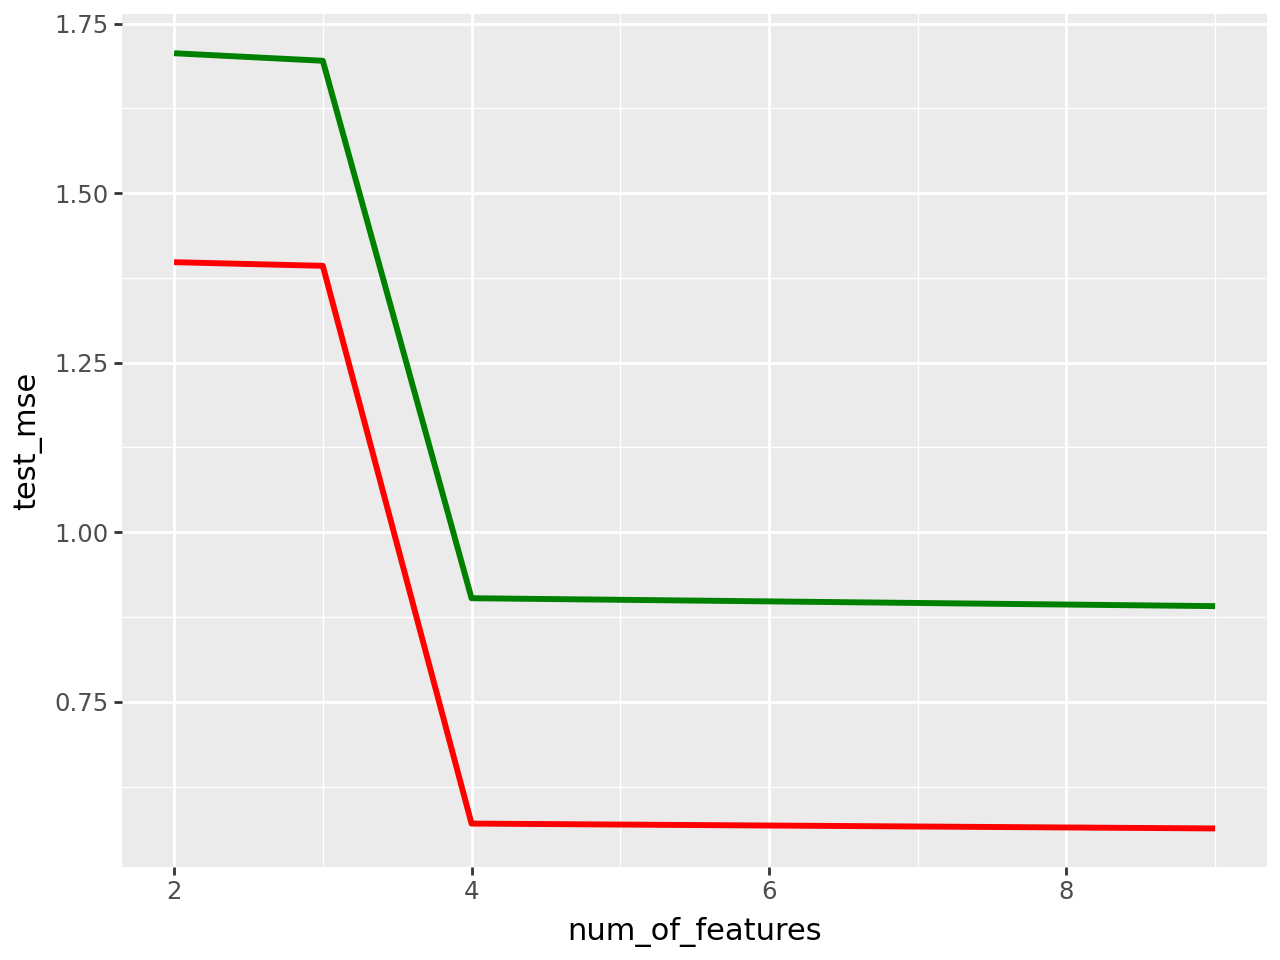

In [33]:
(p9.ggplot(model_selected, p9.aes(x='num_of_features')) +
         p9.geom_line(p9.aes(y='test_mse'), color='green', size=1.2) +
         p9.geom_line(p9.aes(y='train_mse'), color='red', size=1.2)   # Regression line
        )
